### Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib2

plt.style.use('ggplot')
np.random.seed(1)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False

    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]
data = data_thresholded

### 1) Cluster via GMM only considering densities. What's optimal number?

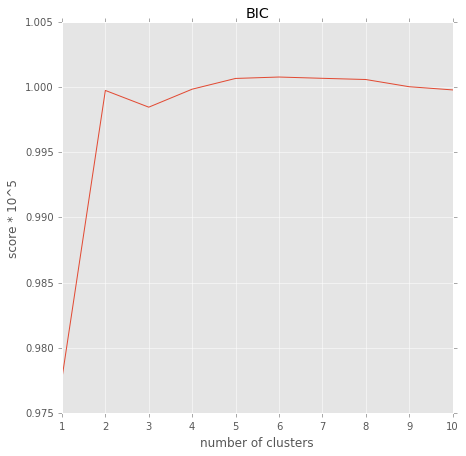

In [2]:
import sklearn.mixture as mixture

# create vector of just densities
dens_vec = (data[:, 4]/data[:, 3])
# normalize
dens_vec = (dens_vec-np.average(dens_vec))/np.std(dens_vec)
dens_vec = np.reshape(dens_vec, (dens_vec.shape[0], 1))

max_clusters = 10
bic = np.array([])
i = np.array(range(1, max_clusters+1))
for idx in i:
    gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag')
    gmm.fit(dens_vec)
    bic = np.append(bic, gmm.bic(dens_vec))

plt.figure(figsize=(7,7))
plt.plot(i, (1.0/bic)*10**5)
plt.title('BIC')
plt.ylabel('score * 10^5')
plt.xlabel('number of clusters')
x1, x2, y1, y2 = plt.axis()
plt.axis((1, max_clusters, y1, y2))
plt.show()

Score appears to be maximized somewhere around 5-7 clusters. Let's choose 5 to keep model simple. Also note elbow at 2 clusters; should examine that in the future.

### 2) Graph these clusters to find trends, etc.

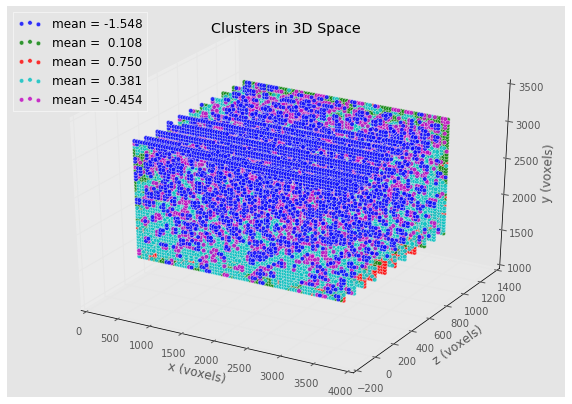

In [3]:
n_clusters = 5
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
labels = gmm.fit_predict(dens_vec)
colors = ['b', 'g', 'r', 'c', 'm']

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

for l, color in zip(range(n_clusters), colors):
    a = np.where(labels == l)
    lab = 'mean = ' + str(gmm.means_[l])[1:7]
    ax.scatter(data[a, 0], data[a, 2], data[a, 1],
               c=color,
               label=lab,
               alpha=.8)
ax.set_xlabel('x (voxels)')
ax.set_ylabel('z (voxels)')
ax.set_zlabel('y (voxels)')
plt.title('Clusters in 3D Space')
plt.legend(loc=2)
plt.show()

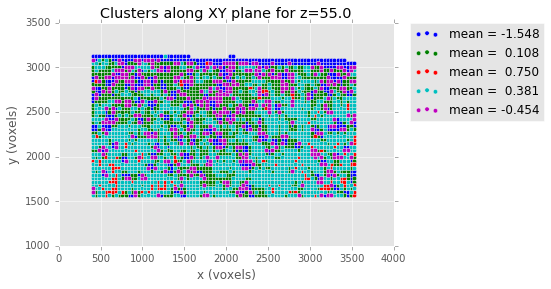

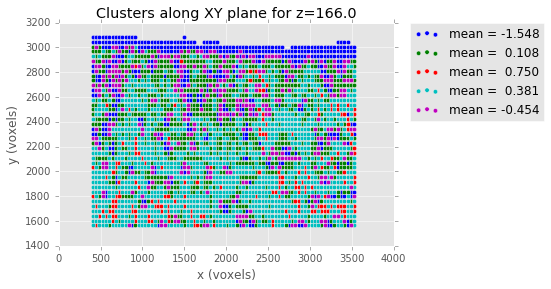

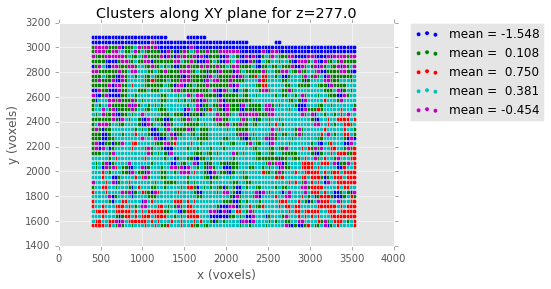

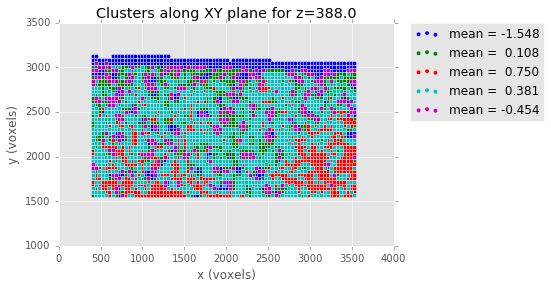

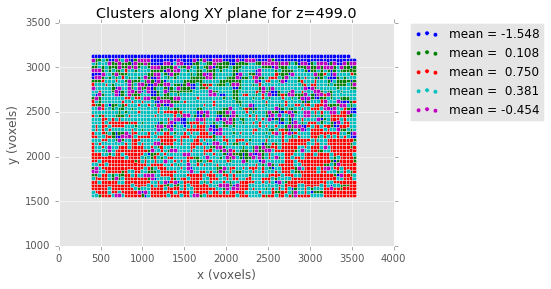

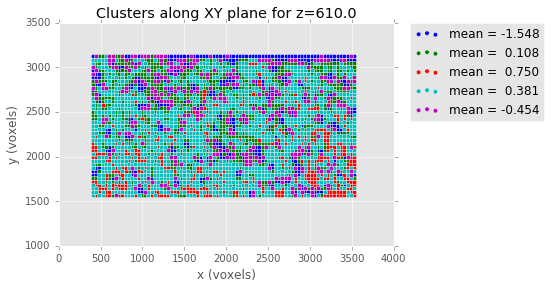

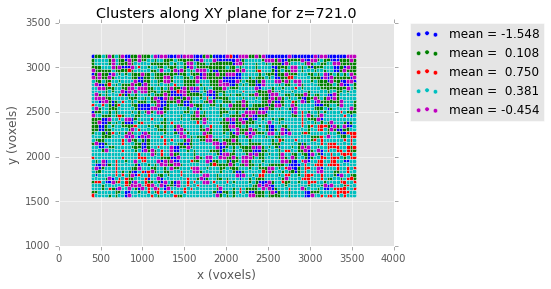

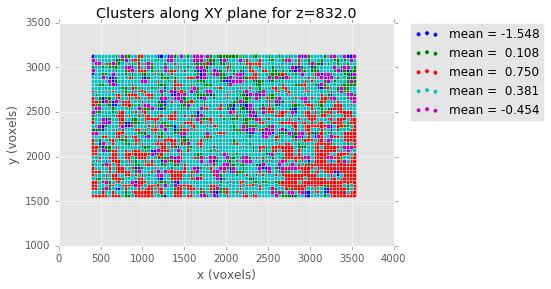

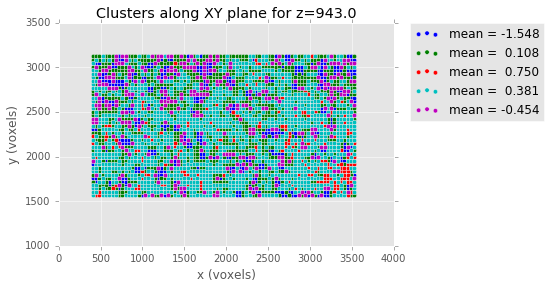

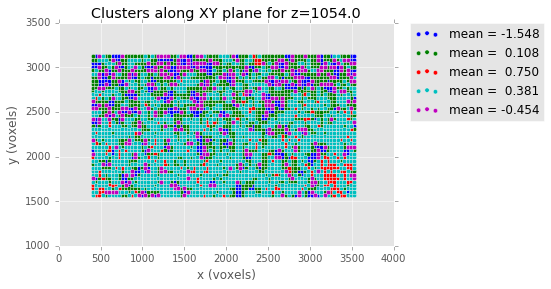

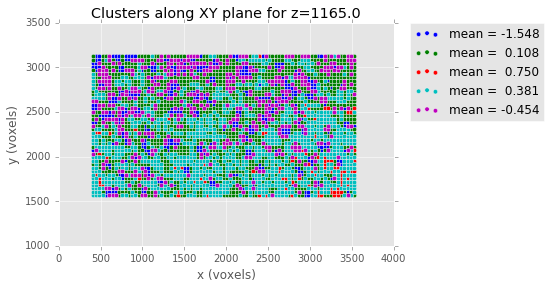

In [4]:
# plot along XY plane
for z in np.unique(data[:, 2]):
    a = np.where(data[:, 2] == z)
    data_z = data[a]
    labels_z = labels[a]
    fig = plt.figure(figsize=(6, 4))
    ax = fig.gca()
    for l, color in zip(range(n_clusters), colors):
        a = np.where(labels_z == l)
        lab = 'mean = ' + str(gmm.means_[l])[1:7]
        ax.scatter(data_z[a, 0], data_z[a, 1],
                   c=color,
                   label=lab)
    plt.title('Clusters along XY plane for z='+str(z))
    plt.xlabel('x (voxels)')
    plt.ylabel('y (voxels)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

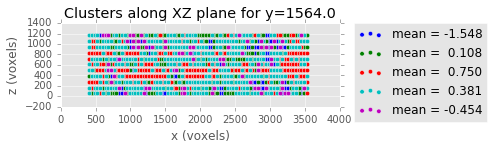

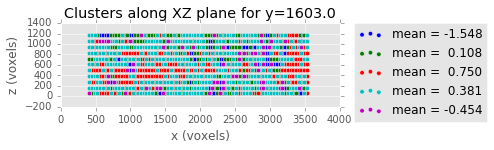

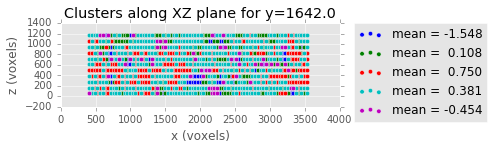

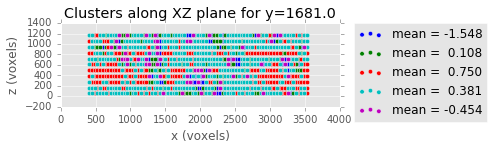

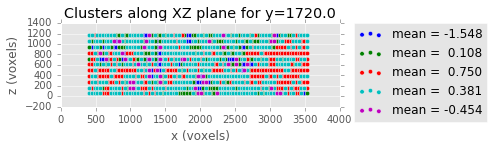

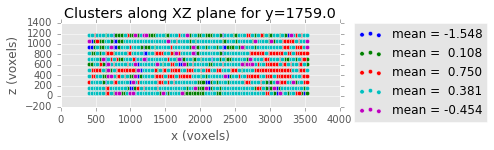

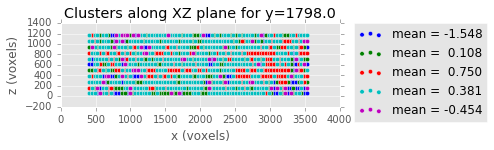

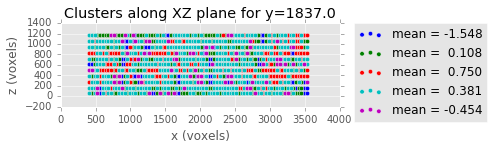

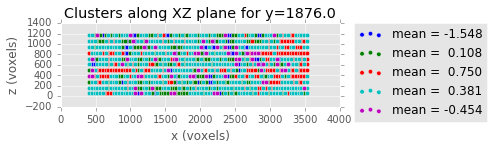

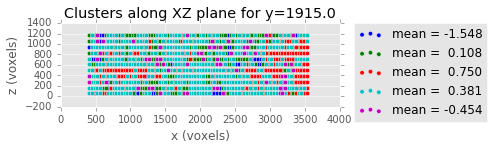

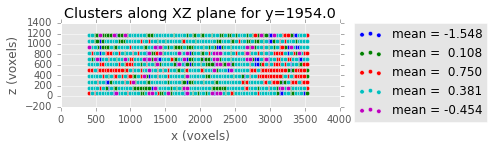

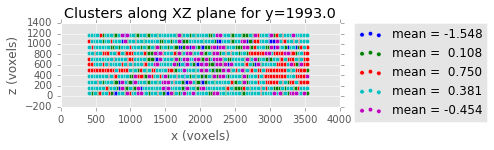

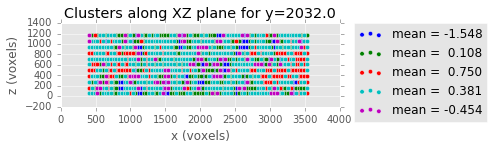

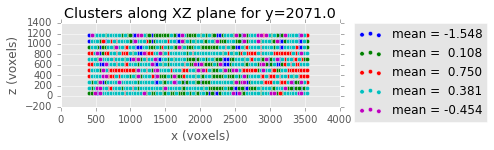

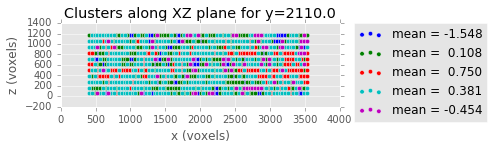

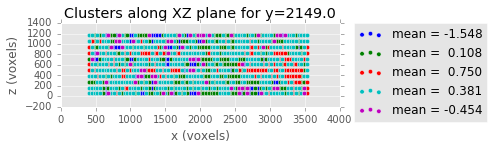

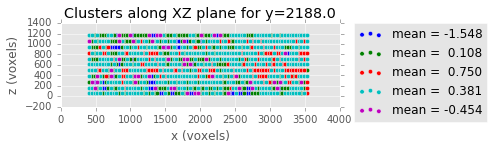

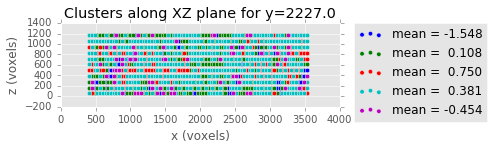

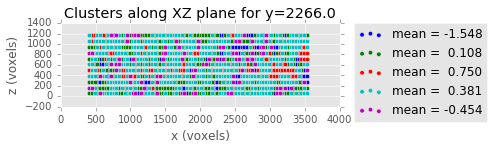

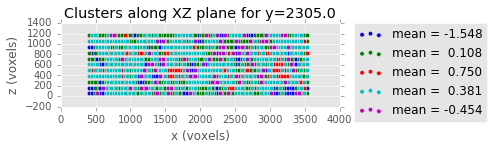

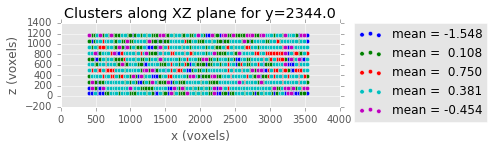

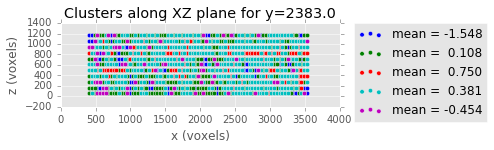

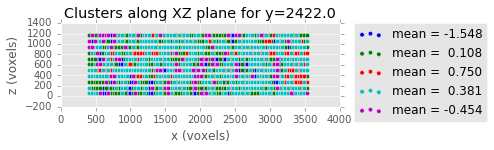

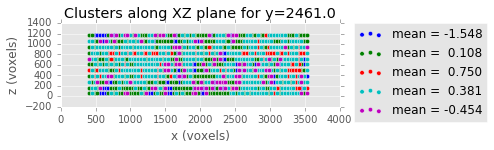

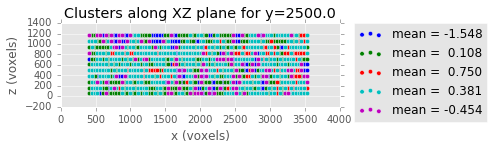

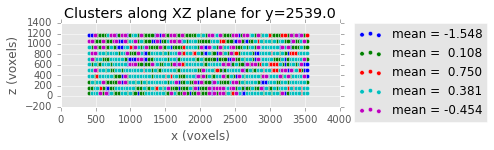

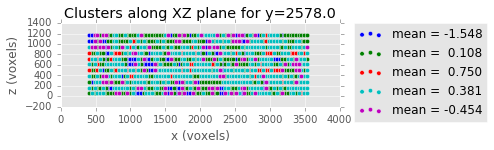

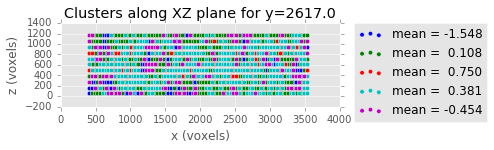

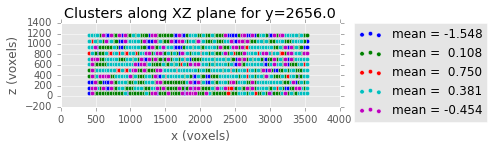

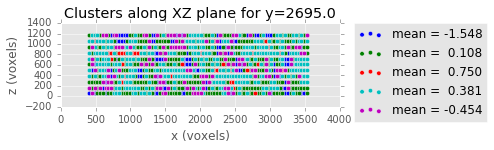

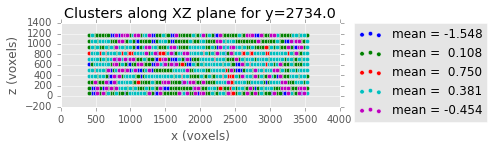

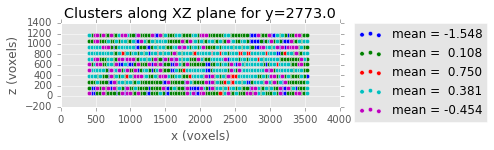

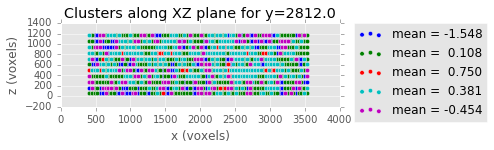

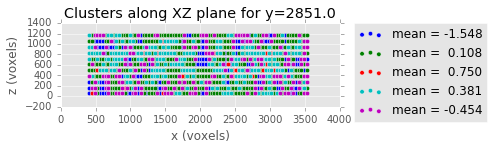

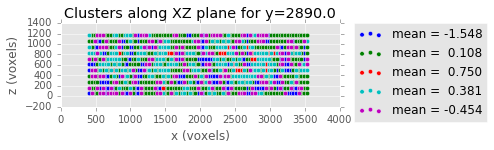

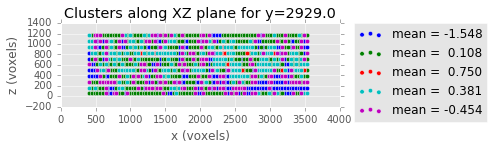

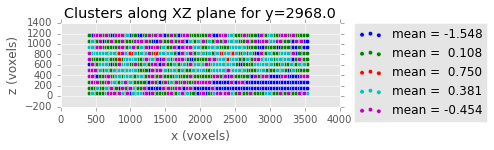

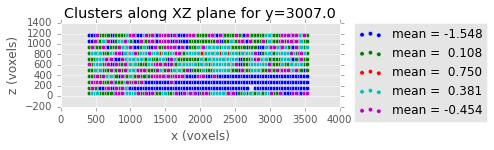

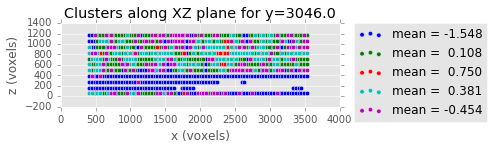

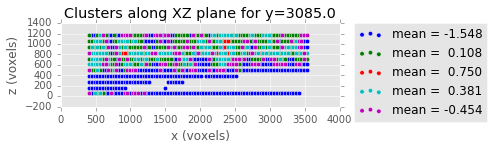

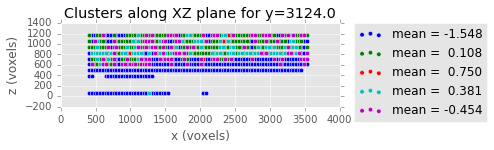

In [5]:
# plot along XZ plane

for y in np.unique(data[:, 1]):
    a = np.where(data[:, 1] == y)
    data_y = data[a]
    labels_y = labels[a]
    fig = plt.figure(figsize=(5, 1.5))
    ax = fig.gca()
    for l, color in zip(range(n_clusters), colors):
        a = np.where(labels_y == l)
        lab = 'mean = ' + str(gmm.means_[l])[1:7]
        ax.scatter(data_y[a, 0], data_y[a, 2],
                   c=color,
                   label=lab)
    plt.title('Clusters along XZ plane for y='+str(y))
    plt.xlabel('x (voxels)')
    plt.ylabel('z (voxels)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

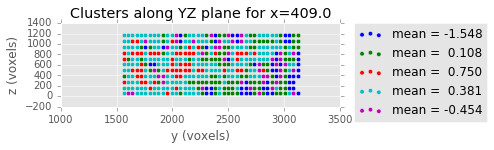

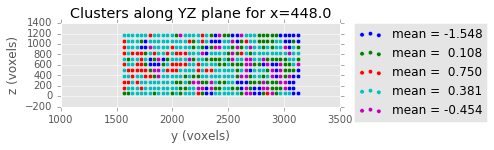

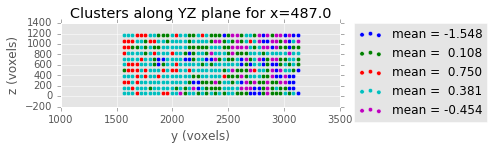

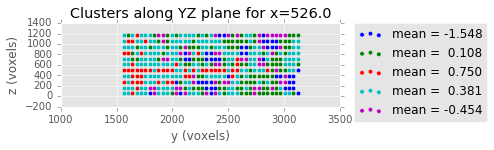

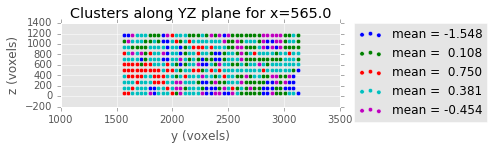

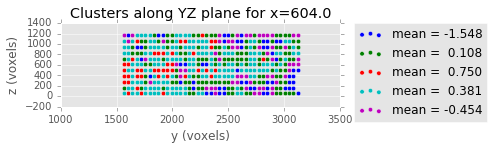

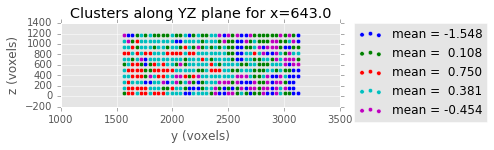

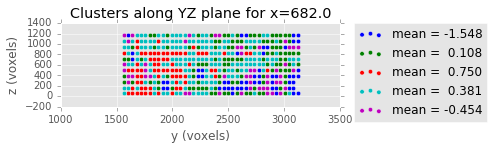

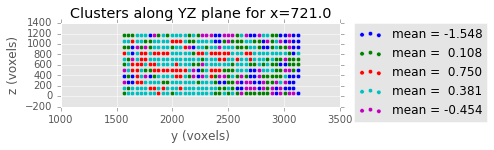

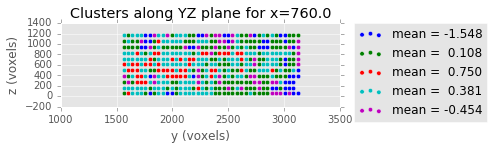

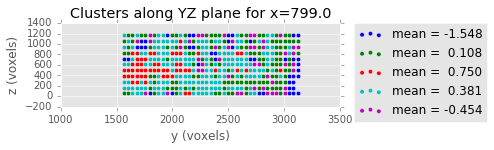

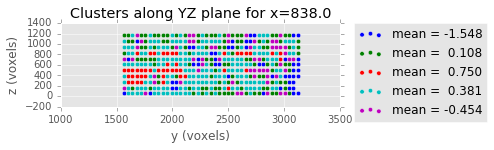

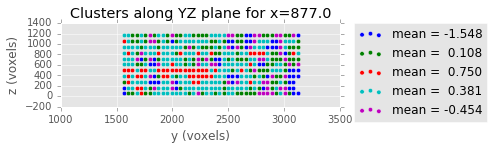

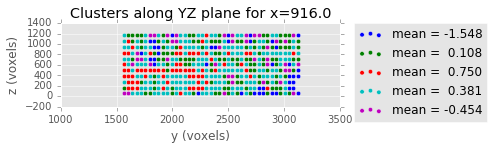

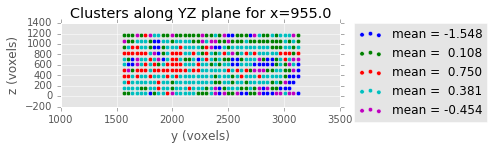

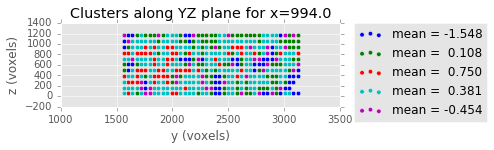

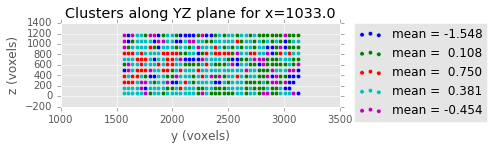

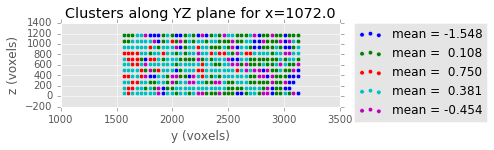

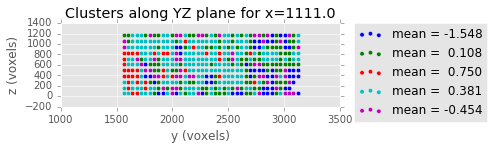

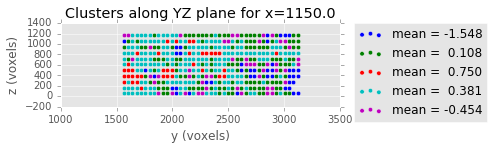

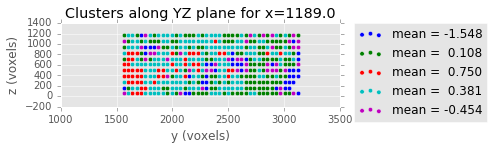

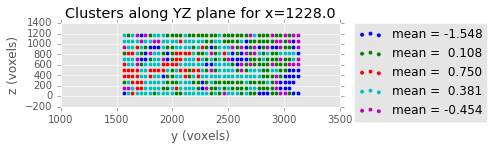

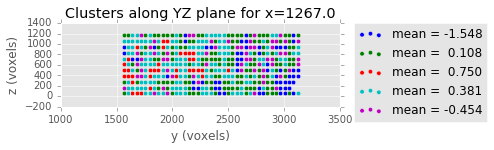

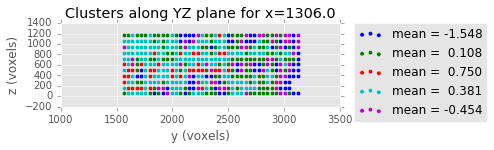

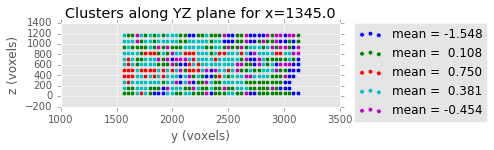

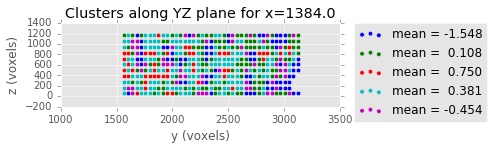

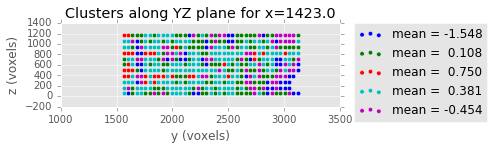

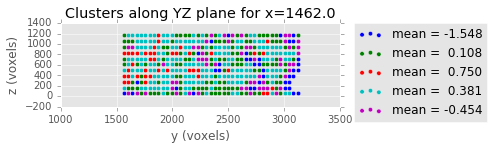

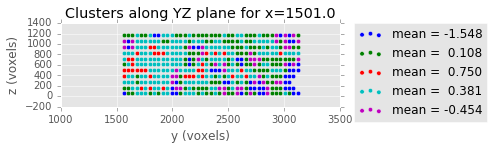

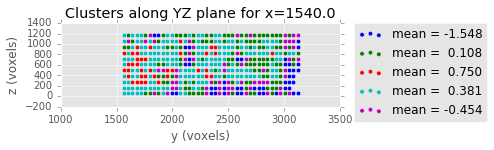

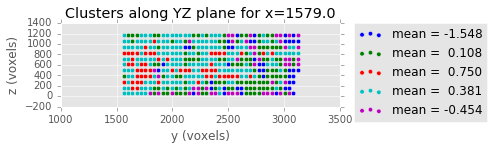

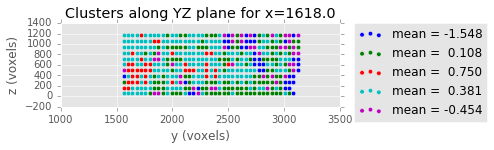

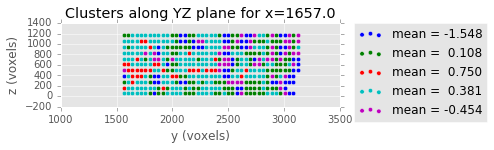

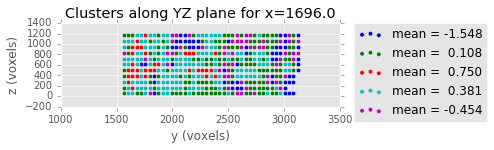

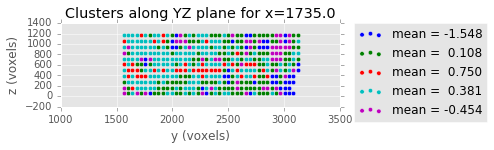

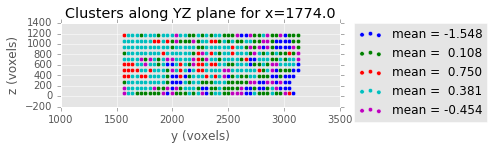

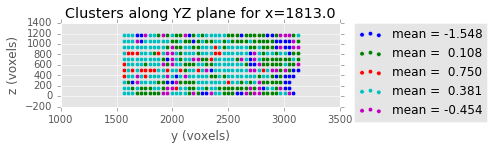

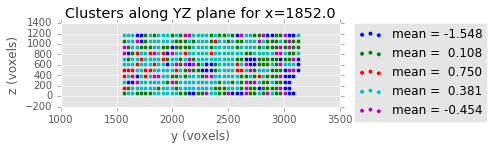

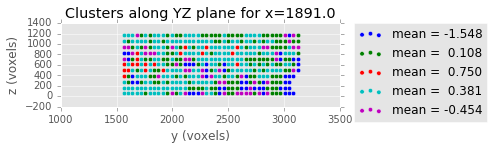

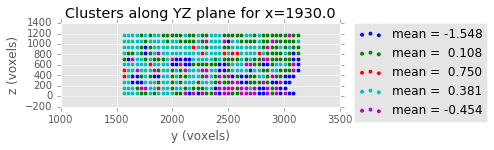

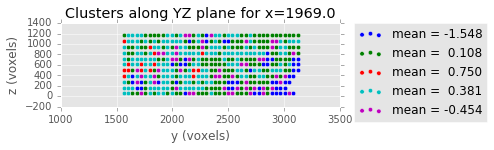

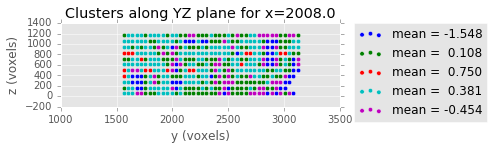

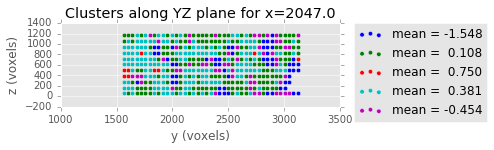

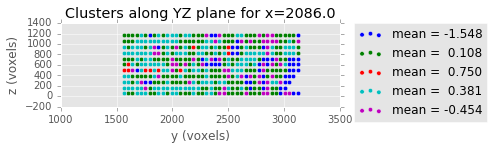

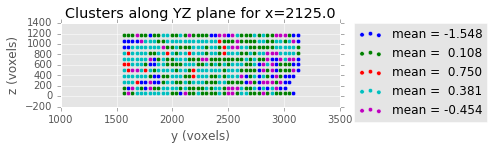

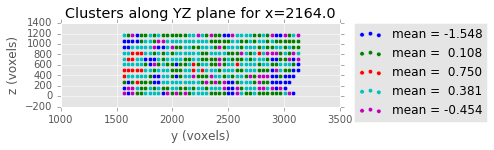

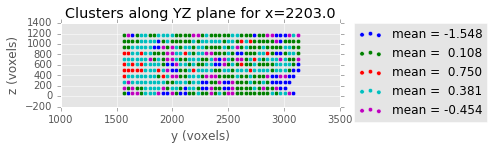

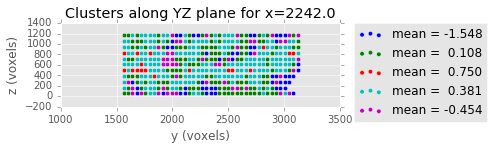

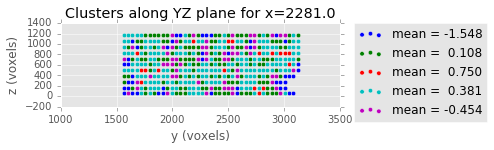

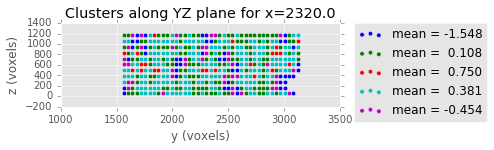

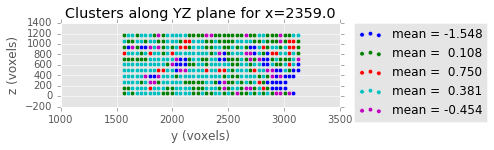

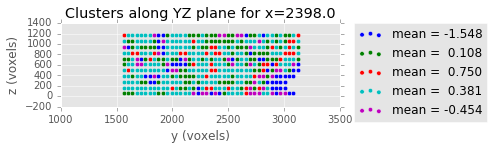

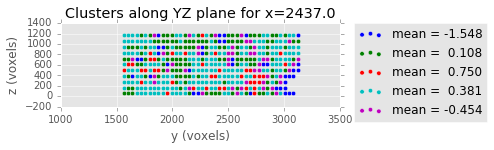

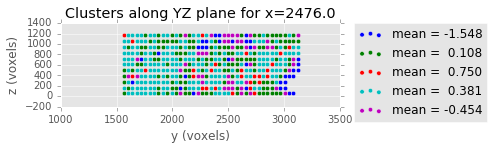

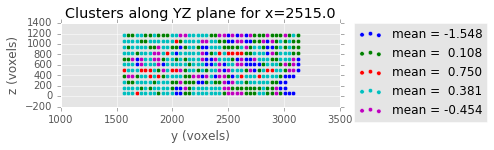

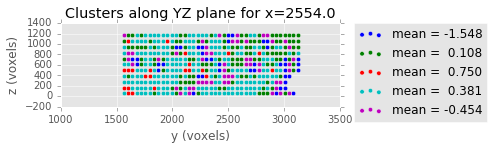

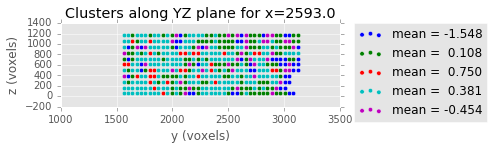

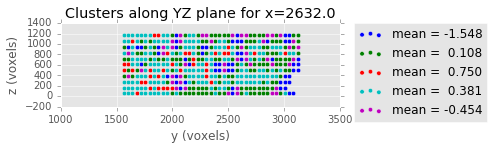

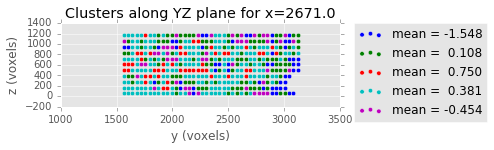

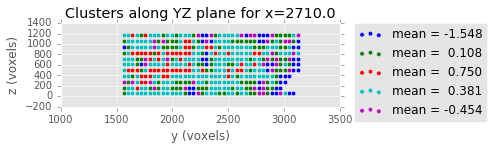

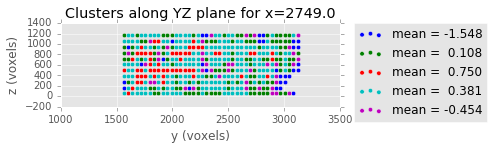

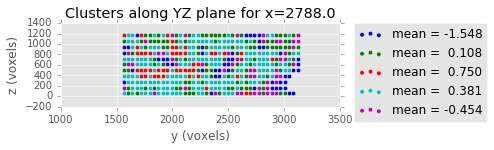

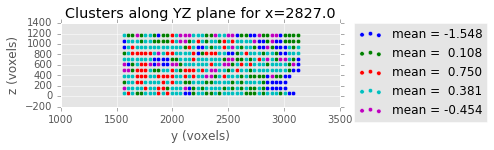

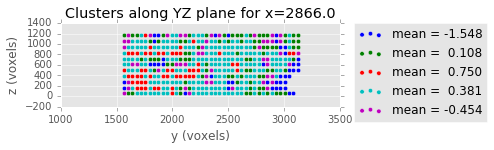

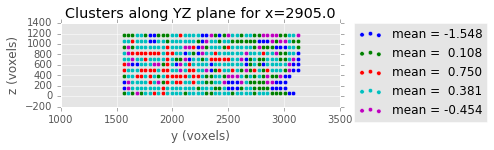

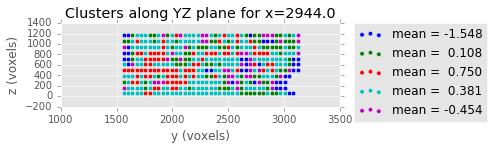

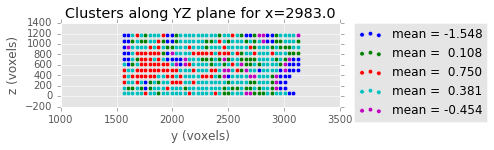

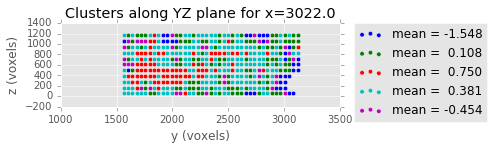

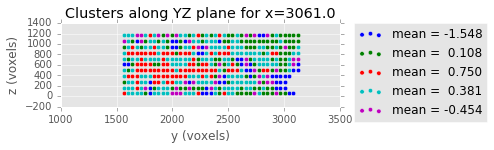

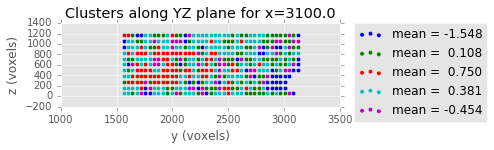

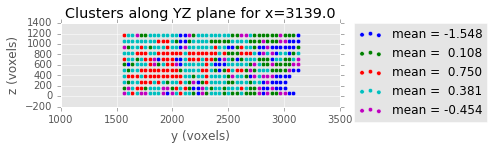

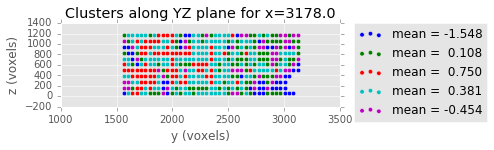

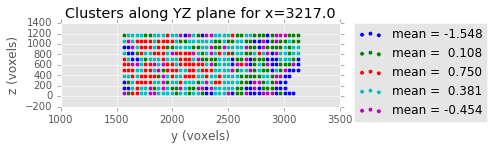

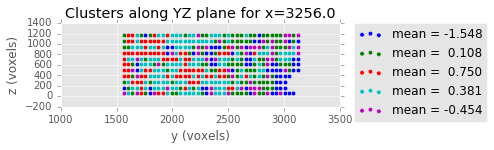

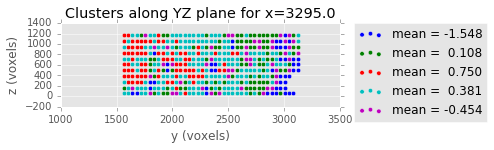

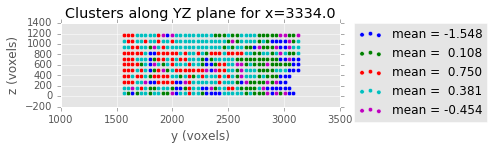

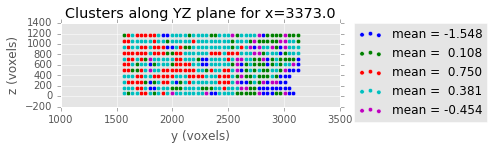

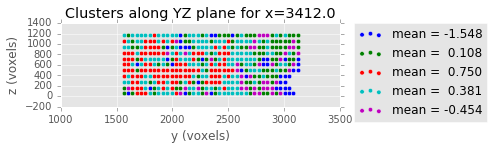

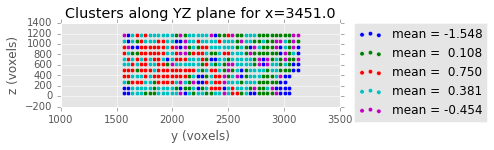

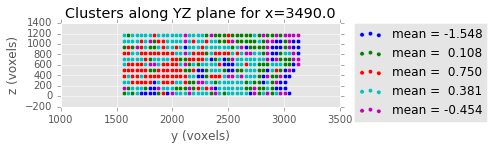

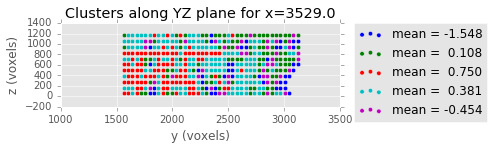

In [6]:
# plot along YZ plane

for x in np.unique(data[:, 0]):
    a = np.where(data[:, 0] == x)
    data_x = data[a]
    labels_x = labels[a]
    fig = plt.figure(figsize=(5, 1.5))
    ax = fig.gca()
    for l, color in zip(range(n_clusters), colors):
        a = np.where(labels_x == l)
        lab = 'mean = ' + str(gmm.means_[l])[1:7]
        ax.scatter(data_x[a, 1], data_x[a, 2],
                   c=color,
                   label=lab)
    plt.title('Clusters along YZ plane for x='+str(x))
    plt.xlabel('y (voxels)')
    plt.ylabel('z (voxels)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

We note some trends in clusters across the level sets. Most interesting are trends involving the red cluster (max density) and the dark blue cluster (min density). To make these more explicit, let's graph just these two clusters in 3D.

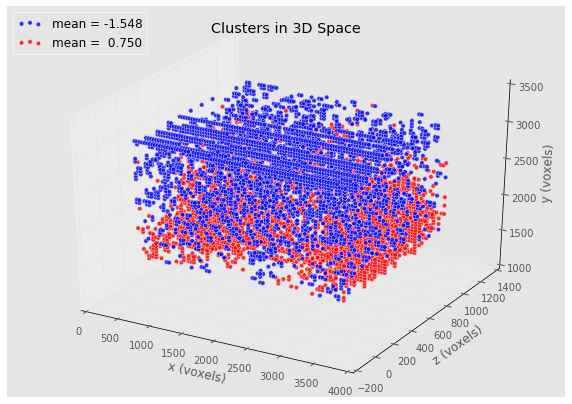

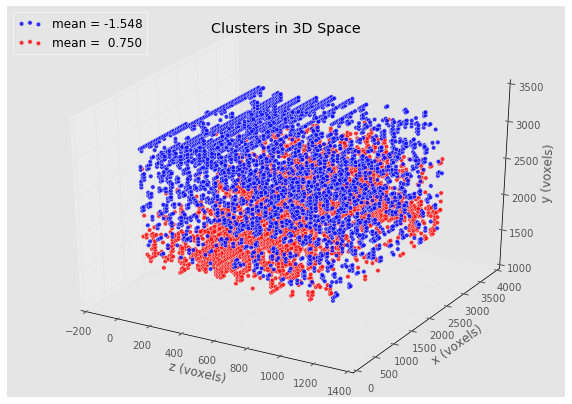

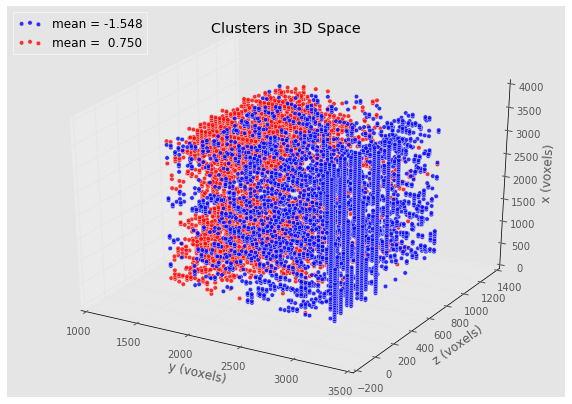

In [7]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

for l, color in zip(range(n_clusters), colors):
    if not (l == 0 or l == 2): continue
    a = np.where(labels == l)
    lab = 'mean = ' + str(gmm.means_[l])[1:7]
    ax.scatter(data[a, 0], data[a, 2], data[a, 1],
               c=color,
               label=lab,
               alpha=.8)
ax.set_xlabel('x (voxels)')
ax.set_ylabel('z (voxels)')
ax.set_zlabel('y (voxels)')
plt.title('Clusters in 3D Space')
plt.legend(loc=2)
plt.show()

# rotated

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

for l, color in zip(range(n_clusters), colors):
    if not (l == 0 or l == 2): continue
    a = np.where(labels == l)
    lab = 'mean = ' + str(gmm.means_[l])[1:7]
    ax.scatter(data[a, 2], data[a, 0], data[a, 1],
               c=color,
               label=lab,
               alpha=.8)
ax.set_xlabel('z (voxels)')
ax.set_ylabel('x (voxels)')
ax.set_zlabel('y (voxels)')
plt.title('Clusters in 3D Space')
plt.legend(loc=2)
plt.show()

# rotated

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

for l, color in zip(range(n_clusters), colors):
    if not (l == 0 or l == 2): continue
    a = np.where(labels == l)
    lab = 'mean = ' + str(gmm.means_[l])[1:7]
    ax.scatter(data[a, 1], data[a, 2], data[a, 0],
               c=color,
               label=lab,
               alpha=.8)
ax.set_xlabel('y (voxels)')
ax.set_ylabel('z (voxels)')
ax.set_zlabel('x (voxels)')
plt.title('Clusters in 3D Space')
plt.legend(loc=2)
plt.show()

### 3) DBSCAN Clustering

In [8]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# density_scale = 3
data_dbscan = np.empty((data.shape[0], 4))
for i in range(3):
    u = np.sort(np.unique(data[:, i]))
    dic = dict(zip(u, range(len(u))))
    coord_rank = np.apply_along_axis(lambda x : dic[x[i]], 1, data[:,])
    # coord_rank = (data[:, i] - np.average(data[:, i]))/np.std(data[:,i])
    data_dbscan[:, i] = coord_rank

data_dbscan[:, 3] = dens_vec.flatten()*10
# adjacent bins at most 3 manhattan distance
# if they're densities within a std dev of each other
epsilon = 13

dbscan = DBSCAN(eps=epsilon, min_samples=800, metric='manhattan')
labels = dbscan.fit_predict(data_dbscan)
n_dbscan_clusters = np.unique(labels).size-1
print "Clusters found:", n_dbscan_clusters
print "Number of datapoints considered noise:", np.count_nonzero(labels == -1)
print "Fraction of datapoints considered noise:", float(np.count_nonzero(labels == -1))/float(data.shape[0])
print "Cluster sizes: "
for i in range(n_dbscan_clusters):
    print np.count_nonzero(labels == i)

Clusters found: 1
Number of datapoints considered noise: 16113
Fraction of datapoints considered noise: 0.447136197136
Cluster sizes: 
19923


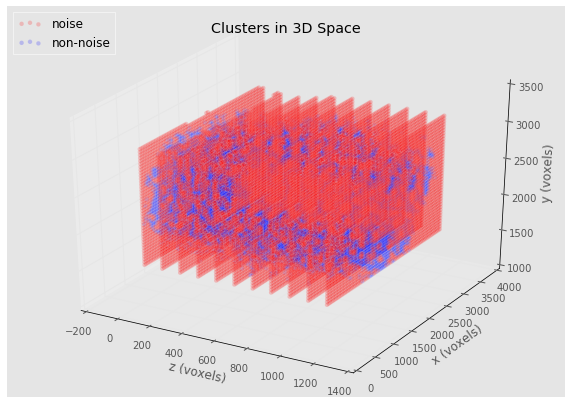

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

a = np.where(labels == -1)
ax.scatter(data[a, 2], data[a, 0], data[a, 1],
           c='r',
           label="noise",
           alpha=.2)

a = np.where(labels == 0)
ax.scatter(data[a, 2], data[a, 0], data[a, 1],
           c='b',
           label="non-noise",
           alpha=.2)
ax.set_xlabel('z (voxels)')
ax.set_ylabel('x (voxels)')
ax.set_zlabel('y (voxels)')
plt.legend(loc=2)
plt.title('Clusters in 3D Space')
plt.show()


In [10]:
a = np.where(labels == 0)
print "Avg non-noise:", np.average(dens_vec[a])
print "Std dev non-noise:", np.std(dens_vec[a])
a = np.where(labels == -1)
print "Avg noise:", np.average(dens_vec[a])
print "Std dev noise:", np.std(dens_vec[a])

Avg non-noise: 0.254957618238
Std dev non-noise: 0.525934581161
Avg noise: -0.315243631115
Std dev noise: 1.30946186606


So we see that DBSCAN found a cluster of density higher than average, with a variance lower than the data as a whole (since we normalized density to have mean 0 and unit variance)... Should investigate this more later.

### 4) Find local max/mins using gradient

[ -7.65112075e-05   9.86860737e-01   1.30627515e-02]
x max/min: 3529.0 409.0
y max/min: 3124.0 1564.0
z max/min: 1165.0 55.0
(2983.0, 3124.0, 277.0)
(1345.0, 3124.0, 277.0)
(3412.0, 3085.0, 277.0)
(3139.0, 3085.0, 277.0)
(1891.0, 3124.0, 277.0)
(3295.0, 3085.0, 277.0)
(3295.0, 3124.0, 166.0)
(3295.0, 3124.0, 277.0)
(1657.0, 3124.0, 166.0)
(1969.0, 3124.0, 166.0)
(1969.0, 3124.0, 277.0)
(2281.0, 3124.0, 166.0)
(2281.0, 3124.0, 277.0)
(3256.0, 3124.0, 166.0)
(3256.0, 3124.0, 277.0)
(1618.0, 3124.0, 166.0)
(1930.0, 3124.0, 166.0)
(1930.0, 3124.0, 277.0)
(2242.0, 3124.0, 166.0)
(2242.0, 3124.0, 277.0)
(1579.0, 3124.0, 166.0)
(2554.0, 3085.0, 277.0)
(2554.0, 3124.0, 166.0)
(2554.0, 3124.0, 277.0)
(1891.0, 3124.0, 166.0)
(2866.0, 3085.0, 277.0)
(2866.0, 3124.0, 166.0)
(2866.0, 3124.0, 277.0)
(2203.0, 3124.0, 166.0)
(2203.0, 3124.0, 277.0)
(2515.0, 3124.0, 166.0)
(2515.0, 3124.0, 277.0)
(2788.0, 3085.0, 277.0)
(1852.0, 3124.0, 166.0)
(2827.0, 3085.0, 277.0)
(2827.0, 3124.0, 166.0)
(2827.0, 31

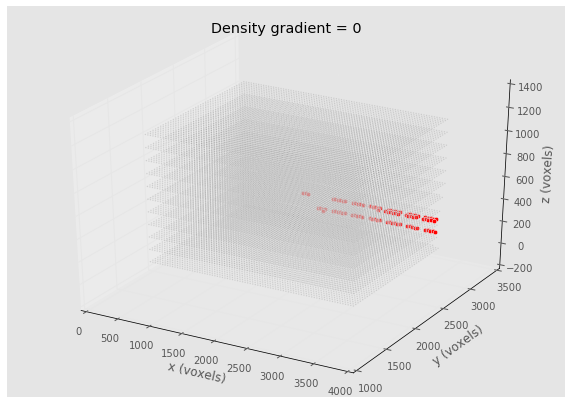

In [11]:
data[:, 3] = dens_vec.flatten()
data = data[:, (0, 1, 2, 3)]
uniques = [np.unique(data[:, i]) for i in xrange(3)]
coord_mapping = {}
for xi, x in enumerate(uniques[0]):
    for yi, y in enumerate(uniques[1]):
        for zi, z in enumerate(uniques[2]):
            coord_mapping[(x, y, z)] = (xi, yi, zi)
gridded_data = np.empty((len(uniques[0]), len(uniques[1]), len(uniques[2])))

for row  in data[:, ]:
    coord = coord_mapping[tuple(row[:3])]
    gridded_data[coord[0], coord[1], coord[2]] = row[-1]

grad = np.gradient(gridded_data)
grad_av = [np.average(grad[0]), np.average(grad[1]), np.average(grad[2])]
print grad_av/np.sum(np.abs(grad_av))
s = grad[0].shape
x = grad[0].flatten()
y = grad[1].flatten()
z = grad[2].flatten()
x0 = set(np.where(x == 0)[0])
y0 = set(np.where(y == 0)[0])
z0 = set(np.where(z == 0)[0])
u = list(set.intersection(x0, y0, z0))
idx = np.unravel_index(np.array(u), s)
inv_map = {v: k for k, v in coord_mapping.items()}
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance
print "x max/min:", np.max(data[:, 0]), np.min(data[:, 0])
print "y max/min:", np.max(data[:, 1]), np.min(data[:, 1])
print "z max/min:", np.max(data[:, 2]), np.min(data[:, 2])
for i in zip(*idx):
    p = inv_map[i]
    print p
    ax.scatter(p[0], p[1], p[2], c='r', s=20)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='grey', alpha=.3, s=2)
ax.set_xlabel('x (voxels)')
ax.set_ylabel('y (voxels)')
ax.set_zlabel('z (voxels)')
plt.title('Density gradient = 0')


From part 2, plotting density clusters, we know that these are likely all local minima. Also know that there is alot of missing data, that is unmasked=0, in the region where all these are occuring. Thus it seems this method of finding local max/min was ultimately not succesful.

### 5) Poisson regression

Going back to the data model I proposed last week (synapse count and thus density are Poisson distributed)... this still, to me, seems like it could be an effective model of the data.

In [34]:
import statsmodels.discrete.discrete_model as discrete_model
indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
data = data_thresholded
d = data[:, 4]/data[:, 3]*(64**3)
poisson = discrete_model.Poisson(d, data[:,(0,1,2)])
res = poisson.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 173.960109
         Iterations 436


In [35]:
print "log likelihood: ", res.llf
print "pseudo r-squared: ", res.prsquared

log likelihood:  -6268826.48609
pseudo r-squared:  -5.5740087793
